# Assignment 8: Correlation Analysis and Hypothesis Testing

## Objective

The field of statistics is divided into two major parts: descriptive and inferential. In this assignment, we will cover two important topics in statistics: correlation analysis and hypothesis testing, where the former belongs to the descriptive part and the latter belongs to the inferential part. After this assignment, you will be able to answer the following questions:

**Correlation Analysis**
1. How to visualize the relationship between two variables?  
2. What is Pearson's correlation? How to compute it?
3. What is Spearman's rank correlation? How to compute it?
4. What's the difference between Pearson's correlation and Spearman's rank correlation? 


**Hypothesis Testing**
1. Why A/B testing?  
2. What is a permutation test? How to implement it?
3. What is p-value? How to avoid p-hacking? 
4. What is a chi-squared test? How to implement it?


In this assignment, you can use [pandas](https://pandas.pydata.org/) or PySpark to manipulate data, and use [matplotlib](https://matplotlib.org/) or [seaborn](seaborn.pydata.org) to make plots. 

## Part 1. Correlation Analysis

As a data scientist, you often face this kind of question: "Are A and B correlated?" For example, 

* Do Canadian Currency and Oil Price move together?
* Do Vancouver Housing Price and US Stock Market have any correlation?
* Are GPA and Gender independent? 

To answer these questions, you need to conduct correlation analysis. 

Imagine you are a data scientist working at a real-estate company. You download a dataset from [property_tax_report_2018.zip](property_tax_report_2018.zip). The dataset contains information on properties from BC Assessment (BCA) and City sources in 2018.  You can find the schema information of the dataset from this [webpage](http://data.vancouver.ca/datacatalogue/propertyTaxAttributes.htm). 

You may think that for a newly built house, it tends to have a higher price than the ones built decades ago. In this assignment, your first job is to figure out whether YEAR_BUILT and HOUSE_PRICE are correlated. 

We first load the data as a DataFrame. 

In [1]:
import pandas as pd
from IPython.display import display

df = pd.read_csv("property_tax_report_2018.csv")

df['HOUSE_PRICE'] = df.apply(lambda x: (x['CURRENT_LAND_VALUE']+x['CURRENT_IMPROVEMENT_VALUE'])/1000000.0, axis = 1)

display(df.head())

,PID,LEGAL_TYPE,FOLIO,LAND_COORDINATE,ZONE_NAME,ZONE_CATEGORY,LOT,BLOCK,PLAN,DISTRICT_LOT,...,CURRENT_LAND_VALUE,CURRENT_IMPROVEMENT_VALUE,TAX_ASSESSMENT_YEAR,PREVIOUS_LAND_VALUE,PREVIOUS_IMPROVEMENT_VALUE,YEAR_BUILT,BIG_IMPROVEMENT_YEAR,TAX_LEVY,NEIGHBOURHOOD_CODE,HOUSE_PRICE
0,025-734-601,STRATA,7.500400e+11,75004024,C-2,Commercial,25,NaN,BCS498,2027,...,592000,242000,2018,472000.0,238000.0,2003.0,2003.0,NaN,3,0.834
1,029-700-868,STRATA,6.381830e+11,63818250,CD-1 (464),Comprehensive Development,132,NaN,EPS2983,200A,...,715000,327000,2018,603000.0,329000.0,NaN,NaN,NaN,13,1.042
2,029-814-227,STRATA,1.708260e+11,17082596,CD-1 (535),Comprehensive Development,25,NaN,EPS3173,311,...,507000,273000,2018,416000.0,273000.0,NaN,NaN,NaN,12,0.780
3,029-918-731,STRATA,6.401940e+11,64019406,IC-3,Light Industrial,40,26,EPS2425,200A,...,227000,170000,2018,168000.0,170000.0,NaN,NaN,NaN,13,0.397
4,017-393-400,STRATA,6.011150e+11,60111496,CD-1 (233),Comprehensive Development,7,NaN,LMS75,185,...,801000,380000,2018,531000.0,385000.0,1991.0,1991.0,NaN,27,1.181


### Task A. Visualizations

Since the housing price varies a lot by locations, we will only consider the houses whose <font color='blue'>postcode starts with 'V6A'</font>. Furthermore, we remove the houses that were <font color='blue'>built before 1900</font>.

<img src="img/v6a.png", width=500/>

In the following, please make two subplots in one row. For the left subplot, it is a scatter plot with X = `YEAR_BUILT` and Y = `HOUSE_PRICE`; for the right subplot, it is a hexbin plot (gridsize = 20) with X = `YEAR_BUILT` and Y = `HOUSE_PRICE`.

I:\Installed\Anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0,0.5,'HOUSE PRICE')

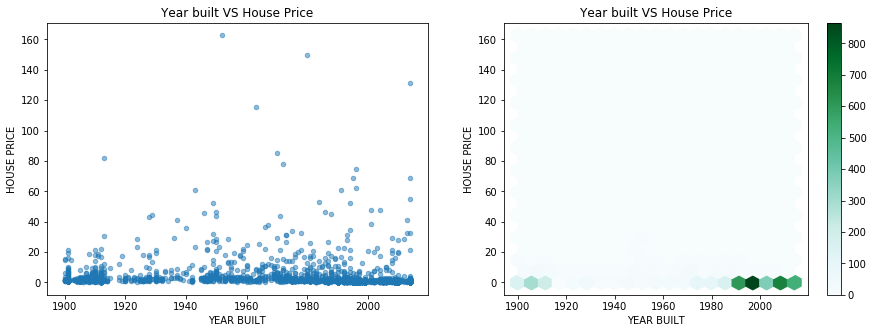

In [2]:
#<-- Write Your Code -->
import matplotlib.pyplot as plt
%matplotlib inline

df_area = df.dropna(subset=['PROPERTY_POSTAL_CODE'])
df_area['area'] = df_area['PROPERTY_POSTAL_CODE'].astype(str).str.strip().str[0:3]
filtered_df = df_area[(df_area["YEAR_BUILT"]>=1900) & (df_area["area"] == "V6A")]

fig, axes = plt.subplots(nrows=1, ncols=2)

scatter = filtered_df.plot.scatter(ax = axes[0], x='YEAR_BUILT',y='HOUSE_PRICE',title='Year built VS House Price',alpha=0.5, figsize=(15,5))
scatter.set_xlabel('YEAR BUILT')
scatter.set_ylabel('HOUSE PRICE')

hexbin = filtered_df.plot.hexbin(ax = axes[1], x='YEAR_BUILT',y='HOUSE_PRICE',title='Year built VS House Price', figsize=(15,5),gridsize=20)
hexbin.set_xlabel('YEAR BUILT')
hexbin.set_ylabel('HOUSE PRICE')

Please write down the **two** most interesting findings that you draw from the plot.

**Findings**
1. From the scatter plot, we can observe that most of the houses in area 'V6A' built after 1900 have price less than 20 million. Correlation between year-built and house price does not exist
2. In hexbin plot, we can observe that the density of the data points (i.e. the number of houses) is very high after around 1990 and below price of 20 million. Still, there is no obvious correlation between year-built and house price from hexbin plot.

The above plots provide a general impression of the relationship between variables. There are some other visualizations that can provide more insight. One option is to bin one variable and plot percentiles of the other. 


In the following, please make three subplots in a row, where each subplot is a scatter plot with X = YEAR_BUILT and Y = HOUSE_PRICE. 
* The first subplot shows how the 25th percentile of `HOUSE_PRICE` changes over years (X = `YEAR_BUILT`, Y = `25TH_HOUSE_PRICE`); 
* The second subplot shows how the 50th percentile of `HOUSE_PRICE` changes over years (X = `YEAR_BUILT`, Y = `50TH_HOUSE_PRICE`); 
* The third subplot shows how the 75th percentile of `HOUSE_PRICE` changes over years (X = `YEAR_BUILT`, Y = `75TH_HOUSE_PRICE`);  


Text(0,0.5,'HOUSE PRICE')

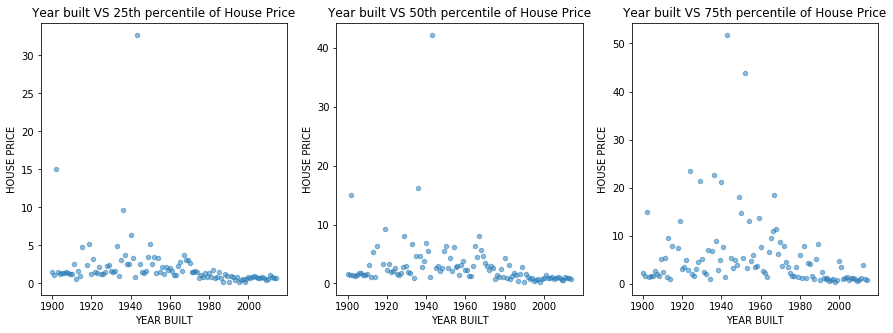

In [3]:
#<-- Write Your Code -->

percentile_df = filtered_df.groupby('YEAR_BUILT')['HOUSE_PRICE'].quantile(.25).reset_index().rename(columns = {'HOUSE_PRICE':'25TH_HOUSE_PRICE'})
percentile_df['50TH_HOUSE_PRICE'] = filtered_df.groupby('YEAR_BUILT')['HOUSE_PRICE'].quantile(.50).reset_index()['HOUSE_PRICE']
percentile_df['75TH_HOUSE_PRICE'] = filtered_df.groupby('YEAR_BUILT')['HOUSE_PRICE'].quantile(.75).reset_index()['HOUSE_PRICE']

fig, axes = plt.subplots(nrows=1, ncols=3)

scatter1 = percentile_df.plot.scatter(ax = axes[0], x='YEAR_BUILT',y='25TH_HOUSE_PRICE',title='Year built VS 25th percentile of House Price',alpha=0.5, figsize=(15,5))
scatter1.set_xlabel('YEAR BUILT')
scatter1.set_ylabel('HOUSE PRICE')

scatter2 = percentile_df.plot.scatter(ax = axes[1], x='YEAR_BUILT',y='50TH_HOUSE_PRICE',title='Year built VS 50th percentile of House Price',alpha=0.5, figsize=(15,5))
scatter2.set_xlabel('YEAR BUILT')
scatter2.set_ylabel('HOUSE PRICE')

scatter3 = percentile_df.plot.scatter(ax = axes[2], x='YEAR_BUILT',y='75TH_HOUSE_PRICE',title='Year built VS 75th percentile of House Price',alpha=0.5, figsize=(15,5))
scatter3.set_xlabel('YEAR BUILT')
scatter3.set_ylabel('HOUSE PRICE')

Please write down the **two** most interesting findings that you draw from the plot.

**Findings**
1. The density of houses over the years is high for house price < 10 Million.
2. Interestingly, the houses built before the year 1980 have higher prices compared to the ones that were built after.

### Task B. Correlation Coefficient

A correlation coefficient is a numerical measure of some type of correlation, meaning a statistical relationship between a pair of variables. 

In the following, please compute the Pearson's correlation as well as Spearman's rank correlation for three pairs of variables: <`25TH_HOUSE_PRICE`, `YEAR_BUILT`>, <`50TH_HOUSE_PRICE`, `YEAR_BUILT`>, and <`75TH_HOUSE_PRICE`, `YEAR_BUILT`>, and then print out your results. 

Note that it is OK to use this [function](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html) to do this task, but make sure that you understand how the numbers are computed. 

In [4]:
#<-- Write Your Code -->
print("Pearson Correlation values for 3 pairs of variables:")
display(percentile_df.corr(method='pearson').iloc[:1,1:])
print("Spearman Correlation values for 3 pairs of variables:")
display(percentile_df.corr(method='spearman').iloc[:1,1:])

Pearson Correlation values for 3 pairs of variables:


,25TH_HOUSE_PRICE,50TH_HOUSE_PRICE,75TH_HOUSE_PRICE
YEAR_BUILT,-0.244533,-0.237504,-0.212677


Spearman Correlation values for 3 pairs of variables:


,25TH_HOUSE_PRICE,50TH_HOUSE_PRICE,75TH_HOUSE_PRICE
YEAR_BUILT,-0.572112,-0.509847,-0.400442


Please write down the **two** most interesting findings that you draw from the result. 

**Findings**
1. All three pairs have monotonic correlation score compared to linear correlation score.
2. All three pairs have negative correlation with small magnitude and 25th percentile House price has highest correlation with year_built compared to other pairs. 

## Part 2. Hypothesis Testing

In many situations, we cannot get the full population but only a sample. If we derive an interesting result from a sample, how likely can we derive the same result from the entire population? In other words, we want to know whether this result is a true finding or it just happens in the sample by chance. Hypothesis testing aims to answer this fundamental question. 

### Task C. A/B Testing
> Acknowledgment: Thank [Greg Baker](http://www.cs.sfu.ca/~ggbaker/) for helping me to prepare this task.

A very common technique to evaluate changes in a user interface is A/B testing: show some users interface A, some interface B, and then look to see if one performs better than the other.

Suppose I started an A/B test on CourSys. Here are the two interfaces that I want to compare with. I want to know whether a good placeholder in the search box can attract more users to use the `search` feature.


![](img/ab-testing.png)

The provided [searchlog.json](./searchlog.json) has information about users' usage. The question I was interested in: is the number of searches per user different?

To answer this question, we need to first pick up a **test statistic** to quantify how good an interface is. Here, we choose "the search_count mean". 

Please write the code to compute **the difference of the search_count means between interface A and Interface B.** 

In [5]:
#<-- Write Your Code -->
log_df = pd.read_json('searchlog.json',lines=True)
mean_df = log_df.groupby('search_ui').mean()['search_count'].reset_index()
display(mean_df)

sc_mean_diff = (mean_df[mean_df['search_ui']=='A']['search_count'][0] - mean_df[mean_df['search_ui']=='B']['search_count'][1])
print("Difference of the search_count means between interface A and interface B is :",round(sc_mean_diff,3))
print("That is the mean search count for interface B is greater than interface A by "+str(round(abs(sc_mean_diff),3)))

,search_ui,search_count
0,A,0.663793
1,B,0.798799


Difference of the search_count means between interface A and interface B is : -0.135
That is the mean search count for interface B is greater than interface A by 0.135


Suppose we find that the mean value increased by 0.135. Then, we wonder whether this result is just caused by random variation. 

We define the Null Hypothesis as
 * The difference in search_count mean between Interface A and Interface B is caused by random variation. 
 
Then the next job is to check whether we can reject the null hypothesis or not. If it does, we can adopt the alternative explanation:
 * The difference in search_count mean  between Interface A and Interface B is caused by the design differences between the two.

We compute the p-value of the observed result. If p-value is low (e.g., <0.01), we can reject the null hypothesis, and adopt  the alternative explanation.  

Please implement a permutation test (numSamples = 10000) to compute the p-value. Note that you are NOT allowed to use an implementation in an existing library. You have to implement it by yourself.

In [6]:
#<-- Write Your Code -->
import numpy as np

def perm_test(input_df,diff,numSamples):
    num = 0
    for j in range(numSamples):
        df = input_df
        np.random.seed(42)
        np.random.shuffle(df['search_ui'].values)
        df = df.groupby('search_ui').mean()['search_count'].reset_index()
        shuffled_diff = (df[df['search_ui']=='A']['search_count'][0] - df[df['search_ui']=='B']['search_count'][1])
        num += shuffled_diff <= diff
    return float(num/numSamples)

pvalue = perm_test(log_df[['search_ui','search_count']],sc_mean_diff,10000)
print("p-value from the permutation test : ",pvalue)
print("Since p-value ({value}) > 0.01, Null Hypothesis has been accepted. i.e., The difference in search_count mean between Interface A and Interface B is caused by random variation.".format(value=pvalue))

p-value from the permutation test :  0.1223
Since p-value (0.1223) > 0.01, Null Hypothesis has been accepted. i.e., The difference in search_count mean between Interface A and Interface B is caused by random variation.


Suppose we want to use the same dataset to do another A/B testing. We suspect that instructors are the ones who can get more useful information from the search feature, so perhaps non-instructors didn't touch the search feature because it was genuinely not relevant to them.

So we decide to repeat the above analysis looking only at instructors.

**Q. If using the same dataset to do this analysis, do you feel like we're p-hacking? If so, what can we do with it? **

**A.** Yes, performing multiple analysis on the dataset to find something significant is p-hacking. To solve this problem, we can decrease the significance level of both the hypothesis tests to α/2 (in this case 0.01/2 = 0.005) and then perform both the tests.

### Task D. Chi-squared test 

There are tens of different hypothesis testing methods. It's impossible to cover all of them in one week. Given that this is an important topic in statistics, I highly recommend using your free time to learn some other popular ones such as <a href="https://en.wikipedia.org/wiki/Chi-squared_test">Chi-Squired test</a>, <a href="https://en.wikipedia.org/wiki/G-test">G-test</a>, <a href="https://en.wikipedia.org/wiki/Student%27s_t-test">T-test</a>, and <a href="https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test">Mann–Whitney U test</a>.

On the searchlog dataset, there are two categorical columns: `is_instructor` and `search_ui`. In Task D, your job is to first learn how a Chi-Squired test works by yourself and then use it to test whether `is_instructor` and `search_ui` are correlated. 

Please write code to compute the contingency table, the chi-squared stat, the degrees of freedom, and the p-value. Note that unlike Task C, you can call any function in an existing library. But, please make sure to understand how those functions are implemented. 

In [7]:
#<-- Write Your Code -->
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(log_df['is_instructor'],log_df['search_ui'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

display(contingency_table)
print('chi-sqaured stat:', chi2)
print('degrees of freedom:', dof)
print('p-value:', p)

search_ui,A,B
is_instructor,,
False,233,213
True,115,120


chi-sqaured stat: 0.5473712356215867
degrees of freedom: 1
p-value: 0.459393799574249


## Submission

Complete Tasks A-D in this [notebook](https://github.com/sfu-db/bigdata-cmpt733/blob/master/Assignments/A8/A8.ipynb), and submit it to the CourSys activity Assignment 8.